# Homework6: Denoising Diffusion generative models

## Task 1: Theory (4pt)

### Problem 1: Faster sampling with DDPM (spaced diffusion) (1pt)

Sampling from DDPM is very slow. In the practical part of HW you will see that it took about 8 seconds to generate a batch of images with our diffusion model (even using a gpu).
While, as you might remember, it took less than a second using other generative models (VAE/GAN/NF).
This drawback can't be solved generally with using more gpus, since it requires iterative sampling.
There are several techniques to alleviate this drawback. In this task We are going to investigate one of them.

Assume we have already trained a model $p(\mathbf{x}_{t - 1} | \mathbf{x}_t, \boldsymbol{\theta})$ to "reverse" a Markov chain of length $T$.

Let try to build inference process using subsequence of timesteps
$\{S_0 = 0, S_1, \ldots, S_{T'-1}, S_{T'} = T\}$, where $T' < T$.

Using this subsequence we have to do $T' (< T)$ inference steps instead of $T$. It could dramatically reduce inference time.

Diffusion models inference are essentially defined by
- schedule of variances $\{\beta_1, \ldots, \beta_T\}$
- reverse process:
$$
p(\mathbf{x}_{S_{t - 1}} | \mathbf{x}_{S_t}, \boldsymbol{\theta}) = \mathcal{N} \bigl(\mathbf{x}_{S_{t - 1}} | \boldsymbol{\mu}_{\boldsymbol{\theta}, S_t}(\mathbf{x}_{S_t}), \tilde{\beta}_{S_t}\bigr)
$$

Therefore, all you have to find is the variances for the new Markov chain: $\{\tilde{\beta}_{S_1}, \ldots, \tilde{\beta}_{S_{T'}}\}$.

**Task:** find the expression for $\tilde{\beta}_{S_t}$ (it should depend on $\alpha$).

### Solution:

$ \alpha_t = 1 - \beta_t, \bar{\alpha}_{s:t} = \prod_{k = s+1}^{t} \alpha_k, \bar{\alpha}_t = \bar{\alpha}_{0:t} $.
$$
q(x_t | x_{t-1})  = \mathcal{N}(x_t | \sqrt \alpha_t x_{t-1}, (1 - \alpha_t)I) $$
$$
q(x_t | x_s)  = \mathcal{N}(x_t | \sqrt{ \bar{\alpha}_{s:t}} x_s, (1 - \bar{\alpha}_{s:t})I) $$
Воспользуемся теоремой Байеса, и понятно, что $ q(x_s | x_t, x_0) = \mathcal{N} (x_s | \hat{\mu_t}, \hat{\beta_t})$
$$
q(x_s | x_t, x_0) = \frac{q(x_t | x_s) q(x_s | x_0)}{q(x_t | x_0)} = \frac{1}{Z} \mathcal{N}(x_t | \sqrt{ \bar{\alpha}_{s:t}} x_s, (1 - \bar{\alpha}_{s:t})I) \mathcal{N}(x_s | \sqrt{ \bar{\alpha}_{0:s}} x_0, (1 - \bar{\alpha}_{0:s})I) = \frac{1}{Z'} exp \left(- \frac{ (x_t - \sqrt{\bar{\alpha}_{s:t}} x_s)^2 }{2 (1 - \bar{\alpha}_{s:t})} - \frac{(x_s - \sqrt{\bar{\alpha}_{0:s}} x_0)^2 }{2 (1 - \bar{\alpha}_{0:s})} \right) = \frac{1}{Z'} exp \left( -\frac{x_t^2 -2x_t \sqrt{ \bar{\alpha}_{s:t}} x_s + \bar{\alpha}_{s:t} x_s^2}{2 (1 - \bar{\alpha}_{s:t})} - \frac{x_s^2 -2x_s \sqrt{ \bar{\alpha}_{0:s}} x_0 + \bar{\alpha}_{0:s} x_0^2}{2 (1 - \bar{\alpha}_{0:s})}  \right) = \frac{1}{Z'} exp \left( -\frac{1}{2} (-\frac{x_t^2 -2x_t \sqrt{ \bar{\alpha}_{s:t}} x_s + \bar{\alpha}_{s:t} x_s^2}{(1 - \bar{\alpha}_{s:t})} - \frac{x_s^2 -2x_s \sqrt{ \bar{\alpha}_{0:s}} x_0 + \bar{\alpha}_{0:s} x_0^2}{(1 - \bar{\alpha}_{0:s})} ) \right)
$$
Рассмотрим показатель экспоненты:
$$
-\frac{x_t^2 -2x_t x_s \sqrt{ \bar{\alpha}_{s:t}} + \bar{\alpha}_{s:t} x_s^2}{(1 - \bar{\alpha}_{s:t})} +  \frac{x_s^2 -2x_s x_0 \sqrt{ \bar{\alpha}_{0:s}} + \bar{\alpha}_{0:s} x_0^2}{(1 - \bar{\alpha}_{0:s})} = \frac{1}{ (1 - \bar{\alpha}_{s:t}) (1 - \bar{\alpha}_{0:s}) }  [ ((1 - \bar{\alpha}_{0:s})  \bar{\alpha}_{s:t} + (1 - \bar{\alpha}_{s:t})) x_s^2 - 2x_s ((1 - \bar{\alpha}_{0:s}) x_t \sqrt{\bar{\alpha}_{s:t}} + (1 - \bar{\alpha}_{s:t}) x_0 \sqrt{\bar{\alpha}_{0:s}} ) + \text{const}(x_0, x_t)]
$$
Отсюда найдем $\hat{\beta}$:
$$
\hat{\beta_s}^{-1} = \frac{ (1 - \bar{\alpha}_{0:s}) \bar{\alpha}_{s:t} + (1 - \bar{\alpha}_{s:t}) }{ (1 - \bar{\alpha}_{s:t}) (1 - \bar{\alpha}_{0:s}) } = \frac{1 - \bar{\alpha}_t}{ (1 - \bar{\alpha}_{s:t}) (1 - \bar{\alpha}_s) } \Rightarrow \hat{\beta_s} = \frac{ 1- \bar{\alpha}_s }{ 1 - \bar{\alpha}_t} (1 - \bar{\alpha}_{s:t})
$$
В данном случае $t = S_t, s = S_{t-1}$, тогда:
$$
\hat{\beta}_{S_t} = \frac{ 1- \bar{\alpha}_{S_{t-1}} }{ 1 - \bar{\alpha}_{S_t}} (1 - \alpha_{S_{t-1}})
$$


### Problem 2: Classifier guidance (1pt)

Consider the label distribution $p(\mathbf{y} | \mathbf{x})$. Assume that we are given the guidance scale $\gamma > 1$.

As we discussed at Lecture 12 the guidance scale sharpens the label distribution:
$$
    \hat{p}(\mathbf{y} | \mathbf{x}) \propto p(\mathbf{y} | \mathbf{x})^\gamma.
$$

In this case conditional distribution equals to
$$
     p(\mathbf{x} | \mathbf{y}, \boldsymbol{\theta}) = \frac{\hat{p}(\mathbf{y} | \mathbf{x}) p(\mathbf{x} | \boldsymbol{\theta})}{\hat{p}(\mathbf{y})}.
$$

Find the expression for $\nabla_{\mathbf{x}} \log p(\mathbf{x} | \mathbf{y}, \boldsymbol{\theta})$ in terms of the initial label distribution $p(\mathbf{y} | \mathbf{x})$.

You have to see that strictly speaking
$$
     \nabla_{\mathbf{x}} \log p(\mathbf{x} | \mathbf{y}, \boldsymbol{\theta}) \neq \gamma \cdot \nabla_{\mathbf{x}} \log p(\mathbf{y} | \mathbf{x}) + \nabla_{\mathbf{x}} \log p(\mathbf{x} | \boldsymbol{\theta}).
$$

### Solution:

$$
     p(\mathbf{x} | \mathbf{y}, \boldsymbol{\theta}) = \frac{\hat{p}(\mathbf{y} | \mathbf{x}) p(\mathbf{x} | \boldsymbol{\theta})}{\hat{p}(\mathbf{y})}
$$
$$
    \hat{p}(\mathbf{y} | \mathbf{x}) = \frac{p(\mathbf{y} | \mathbf{x})^\gamma}{Z} = \frac{p(\mathbf{y} | \mathbf{x})^\gamma}{\int p(\mathbf{y} | \mathbf{x})^\gamma d \mathbf{y}}
$$
$$
    \log p(\mathbf{x} | \mathbf{y}, \boldsymbol{\theta}) = \log \hat{p}(\mathbf{y} | \mathbf{x}) +  \log p(\mathbf{x} | \boldsymbol{\theta}) - \log \hat{p}(\mathbf{y}) = \gamma \log p(\mathbf{y} | \mathbf{x}) - \log \left( \int p(\mathbf{y} | \mathbf{x})^\gamma d \mathbf{y} \right) +  \log p(\mathbf{x} | \boldsymbol{\theta}) - \log \hat{p}(\mathbf{y})
$$
$$
     \nabla_{\mathbf{x}} \log p(\mathbf{x} | \mathbf{y}, \boldsymbol{\theta}) = \gamma \cdot \nabla_{\mathbf{x}} \log p(\mathbf{y} | \mathbf{x}) + \nabla_{\mathbf{x}} \log p(\mathbf{x} | \boldsymbol{\theta}) - \nabla_{\mathbf{x}} \log \left( \int p(\mathbf{y} | \mathbf{x})^\gamma d \mathbf{y} \right), \quad \nabla_{\mathbf{x}} \log \left( \int p(\mathbf{y} | \mathbf{x})^\gamma d \mathbf{y} \right) \neq 0
$$ since $ p(\mathbf{y} | \mathbf{x})^\gamma $ is not probability density function, and its integral in not equal to 1.

### Problem 3: KFP theorem (2pt)

In Lecture 13 we have faced with 2 different formulations of Kolmogorov-Fokker-Planck theorem.

1) We used the following KFP theorem when we discussed continuous-in-time NF:
$$
\frac{d \log p(\mathbf{x}(t), t)}{d t} = - \text{tr} \left( \frac{\partial f(\mathbf{x}, t)}{\partial \mathbf{x}} \right).
$$

2) We used the following KFP theorem when we discussed SDEs:
$$
\frac{\partial p(\mathbf{x}, t)}{\partial t} = \text{tr}\left(- \frac{\partial}{\partial \mathbf{x}} \bigl[ \mathbf{f}(\mathbf{x}, t) p(\mathbf{x}, t)\bigr] + \frac{1}{2} g^2(t) \frac{\partial^2 p(\mathbf{x}, t)}{\partial \mathbf{x}^2} \right)
$$

In this task your goal is to prove that the first formulation is a special case of the more general second formulation.

You have to use two facts:
1) Continuous-in-time NF use ODE (not SDE).
2) The derivation in the first formulation is total derivative (not partial).

### Solution:

$$
d \mathbf{x} = f(\mathbf{x}, t) dt + g(t) dw
$$
Continuous-in-time NF use ODE (not SDE), so we will immediately drop stochastic part and put it $ g(t) \equiv 0  \Rightarrow d\mathbf{x} = f(\mathbf{x}, t)dt$.
$$
\frac{\partial p(\mathbf{x}, t)}{\partial t} = \text{tr}\left(- \frac{\partial}{\partial \mathbf{x}} \bigl[ \mathbf{f}(\mathbf{x}, t) p(\mathbf{x}, t)\bigr] \right) = \text{tr} \left(-p(\mathbf{x}, t) \frac{\partial f(\mathbf{x}, t)}{\partial \mathbf{x}} -f(\mathbf{x}, t) \frac{\partial p(\mathbf{x}, t)}{\partial \mathbf{x}}  \right) = \\ -\text{tr} \left(p(\mathbf{x}, t) \frac{\partial f(\mathbf{x}, t)}{\partial \mathbf{x}}  \right) - \text{tr} \left(f(\mathbf{x}, t) \frac{\partial p(\mathbf{x}, t)}{\partial \mathbf{x}}  \right)
$$ \\
$$
\frac{d \log p(\mathbf{x}(t), t)}{d t} = - \text{tr} \left( \frac{\partial f(\mathbf{x}, t)}{\partial \mathbf{x}} \right).
$$
$$
\frac{d \log p(\mathbf{x}(t), t)}{d t} = \frac{1}{p(\mathbf{x}(t), t)} \frac{d p(\mathbf{x}(t), t)}{dt}, \quad \frac{d p(\mathbf{x}, t)}{dt} = \sum_{i} \frac{\partial p(x_i, t)}{\partial x_i} \frac{d x_i}{dt} + \frac{\partial p(\mathbf{x}, t)}{\partial t} = - p(\mathbf{x}, t) \text{tr} \left( \frac{\partial f(\mathbf{x}, t)}{\partial \mathbf{x}} \right)
 \Rightarrow \frac{\partial p(\mathbf{x}, t)}{\partial t} = - p(\mathbf{x}, t) \text{tr} \left( \frac{\partial f(\mathbf{x}, t)}{\partial \mathbf{x}} \right) - \sum_{i} \frac{\partial p(x_i, t)}{\partial x_i} f(x_i, t) = - p(\mathbf{x}, t) \text{tr} \left( \frac{\partial f(\mathbf{x}, t)}{\partial \mathbf{x}} \right) - \text{tr} \left(\frac{\partial p(\mathbf{x}, t)}{\partial \mathbf{x}} f(\mathbf{x}, t)  \right) = \\  - \text{tr} \left( p(\mathbf{x}, t)  \frac{\partial f(\mathbf{x}, t)}{\partial \mathbf{x}} \right) - \text{tr} \left(\frac{\partial p(\mathbf{x}, t)}{\partial \mathbf{x}} f(\mathbf{x}, t)  \right) = \text{tr}\left(- \frac{\partial}{\partial \mathbf{x}} \bigl[ \mathbf{f}(\mathbf{x}, t) p(\mathbf{x}, t)\bigr] \right)
$$

In [ ]:
!pip install --upgrade --no-cache-dir gdown

COMMIT_HASH = "b4df45506b5dc4cd055cb00facebc504fd57571a"
!if [ -d dgm_utils ]; then rm -Rf dgm_utils; fi
!git clone https://github.com/r-isachenko/dgm_utils.git
%cd dgm_utils
!git checkout {COMMIT_HASH}
!pip install ./
%cd ./..
!rm -Rf dgm_utils

Cloning into 'dgm_utils'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 33 (delta 16), reused 16 (delta 5), pack-reused 0
Unpacking objects: 100% (33/33), 13.19 KiB | 1.46 MiB/s, done.
/kaggle/working/dgm_utils
Note: switching to 'b4df45506b5dc4cd055cb00facebc504fd57571a'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at b4df455 Clear output after sampling
Processing /kaggle/working/dgm_utils
  Preparing metad

In [ ]:
!pip3 install wandb

In [ ]:
from tqdm import tqdm
from typing import List, Tuple
from copy import deepcopy
import matplotlib.pyplot as plt

import dgm_utils

from IPython.display import clear_output
import wandb
from typing import Tuple, Dict, Optional, Union

import numpy as np
import seaborn as sns
from sklearn.datasets import make_moons

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision.utils import make_grid

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Task 2: DDPM for 2D data (5 pts)

In this part you have to implement your own diffusion model (DDPM) and apply it to 2D dataset.

Let's take a look at dataset samples.

In [ ]:
def generate_moons_data(count: int) -> tuple:
    data, labels = make_moons(n_samples=count, noise=0.1)
    data = data.astype("float32")
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    train_labels, test_labels = labels[:split], labels[split:]
    return train_data, train_labels, test_data, test_labels

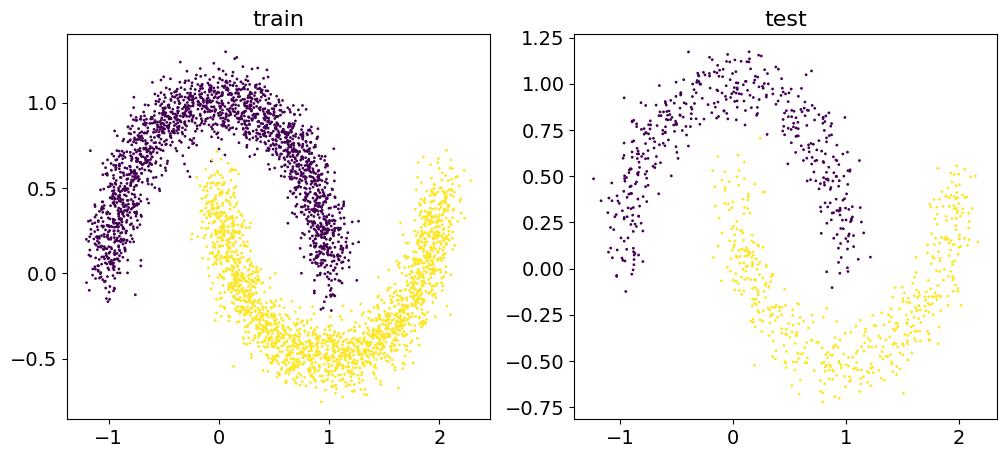

In [ ]:
COUNT = 5000

train_data, train_labels, test_data, test_labels = generate_moons_data(COUNT)
dgm_utils.visualize_2d_data(train_data, test_data, train_labels, test_labels)

Below you see the utility function, which broadcasts tensors. Look carefully at this code, we will use it in the majority of methods.

In [ ]:
def _extract_into_tensor(arr, indices, broadcast_shape):
    """
    Extract values from a 1-D torch tensor for a batch of indices.
    :param arr: 1-D torch tensor.
    :param timesteps: a tensor of indices to extract from arr.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    assert len(arr.shape) == 1
    res = arr.to(device=indices.device)[indices].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]


    return res.expand(broadcast_shape)

### Forward Diffusion

Let start with forward diffusion.

**Forward process** is defined as a posterior distribution $q(\mathbf{x}_{1:T}|\mathbf{x}_0)$.

It is a Markov chain, which consequently adds gaussian noise to a given object $\mathbf{x}_0$.

At every step of this process the gaussian noise is added with different magnitude, which is determined with a schedule of variances $\{\beta_1, ... \beta_T\}$.
If this schedule is chosen properly and T goes to infinity (or is large enough), we will converge to pure noise $\mathcal{N}(0, I)$.

Markov chain is defined by:
$$
 q(\mathbf{x}_t | \mathbf{x}_{t - 1}) = \mathcal{N}(\mathbf{x}_t | \sqrt{1 - \beta_t}\mathbf{x}_{t - 1}, \beta_t \mathbf{I}), \quad q(\mathbf{x}_{1:T}|\mathbf{x}_0) = \prod_{t = 1}^T q(\mathbf{x}_t | \mathbf{x}_{t - 1})
$$

In order to get $\mathbf{x}_t$ we have to compute $\mathbf{x}_1, ..., \mathbf{x}_{t - 1}$ iteratively.

Hopefully, due to the properties of the gaussian distribution we can do it more efficiently.

Let's denote
$\alpha_t = 1- \beta_t$ и $\bar{\alpha}_t= \prod_{s = 1}^t\alpha_s$.
Then
$$
q(\mathbf{x}_t | \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t|\sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1-\bar{\alpha}_t) \mathbf{I}).
\tag{1}
$$

Here we could get very useful expression
$$
    \mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t} \cdot \boldsymbol{\epsilon}. \tag{2}
$$

Now we will create base class for diffusion (we will use it as a python base class for forward and backward diffusions).

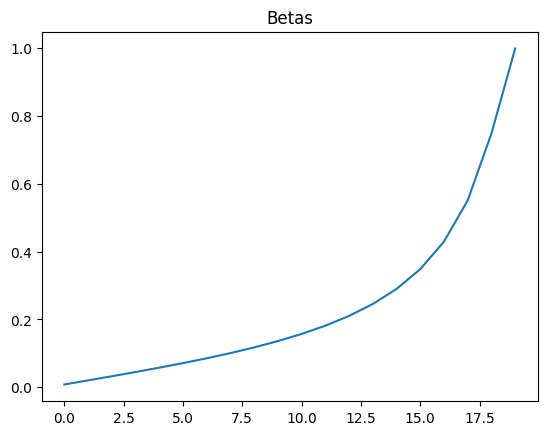

In [ ]:
class BaseDiffusion:
    def __init__(self, num_timesteps: int):
        self.num_timesteps = num_timesteps
        self.betas = self._get_beta_schedule(num_timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=-1)

    @staticmethod
    def _get_beta_schedule(num_diffusion_timesteps, s=0.008):
        def f(t, T):
            return (np.cos((t / T + s) / (1 + s) * np.pi / 2)) ** 2

        alphas = []
        f0 = f(0, num_diffusion_timesteps)

        for t in range(num_diffusion_timesteps + 1):
            alphas.append(f(t, num_diffusion_timesteps) / f0)

        betas = []

        for t in range(1, num_diffusion_timesteps + 1):
            betas.append(min(1 - alphas[t] / alphas[t - 1], 0.999))

        return torch.from_numpy(np.array(betas)).double()


basediff = BaseDiffusion(num_timesteps=20)

plt.title('Betas')
plt.plot(basediff.betas.numpy())
plt.show()

We are ready to define forward diffusion process. It has 2 methods:
- to get mean and variance of the distribution $q(\mathbf{x}_t | \mathbf{x}_0)$,
- to get samples from this distribution.

In [ ]:
class ForwardDiffusion(BaseDiffusion):
    def get_mean_variance(self, x0, t):
        # ====
        # your code
        # calculate mean and variance of the distribution q(x_t | x_0) (use equation (1))
        # use _extract_into_tensor() function to get tensors of the same shape as x0
        mean = _extract_into_tensor(torch.sqrt(self.alphas_cumprod), t, x0.shape)
        variance = _extract_into_tensor(1 - self.alphas_cumprod, t, x0.shape)
        # ====
        return mean, variance

    def get_samples(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        # ====
        # your code
        # sample from the distribution q(x_t | x_0) (use equation (2))

        # ====
        mean, variance = self.get_mean_variance(x0, t)
        samples = mean * x0 + torch.sqrt(variance) * noise
        return samples


def test_forward_diffusion():
    fdiff = ForwardDiffusion(num_timesteps=100)
    SHAPE = [2, 20]
    x0 = torch.ones(SHAPE)
    t = torch.ones((2,)).long() * 5
    mean, variance = fdiff.get_mean_variance(x0=x0, t=t)
    assert list(mean.shape) == SHAPE
    assert list(variance.shape) == SHAPE
    assert np.allclose(mean.numpy(), np.ones(SHAPE) * 0.9944681)
    assert np.allclose(variance.numpy(), np.ones(SHAPE) * 0.01103322)

    xt = fdiff.get_samples(x0=x0, t=t)
    assert list(xt.shape) == SHAPE

    noise = torch.ones(SHAPE)
    xt = fdiff.get_samples(x0=x0, t=t, noise=noise)
    assert np.allclose(xt.numpy(), np.ones(SHAPE) * 1.0995072)


test_forward_diffusion()

Let visualize the forward diffusion process. Here you have to see how the distribution of the real samples transforms to the gaussian noise.

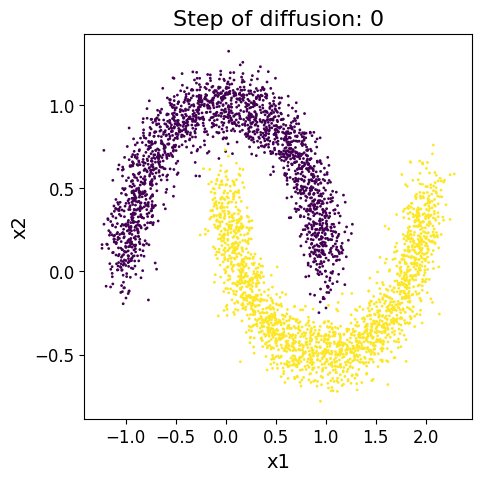

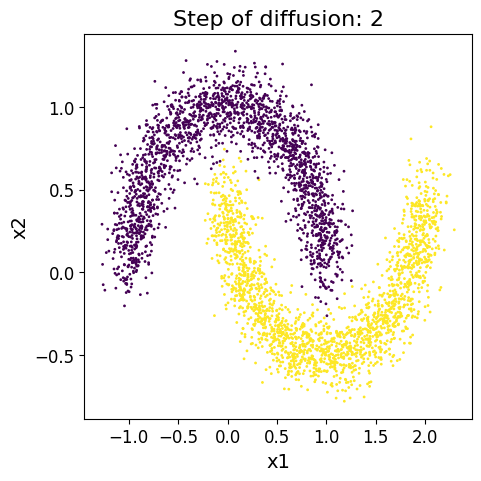

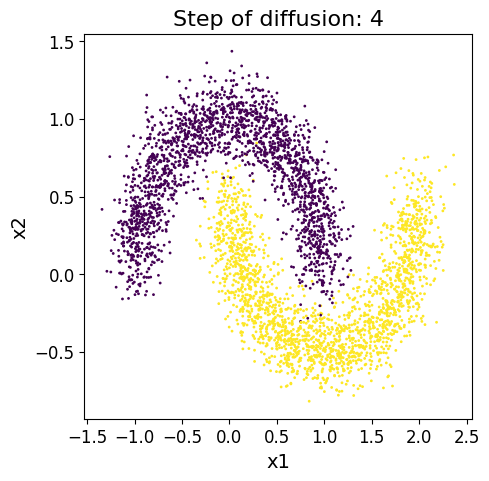

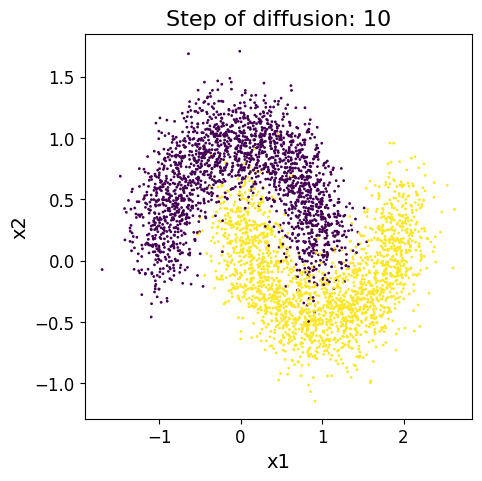

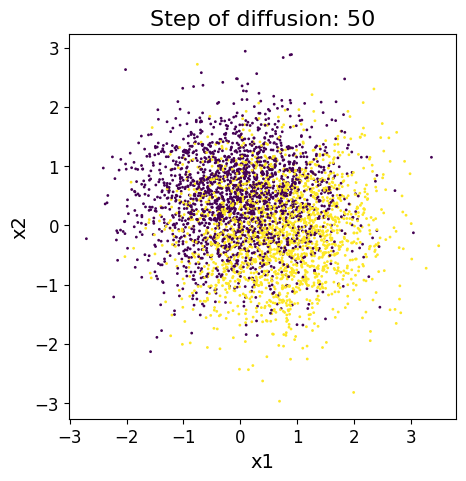

In [ ]:
T = 100

fdiff = ForwardDiffusion(num_timesteps=T)

timestamps=[0, 2, 4, 10, 50]

plot_n_steps = len(timestamps)
for i, t in enumerate(timestamps):
    x = fdiff.get_samples(x0=torch.from_numpy(train_data), t=torch.ones((train_data.shape[0], 1)).long() * t)
    dgm_utils.visualize_2d_samples(x, title=f"Step of diffusion: {t}", labels=train_labels)

### Reverse Diffusion

**Reverse process** consequently denoises pure gaussian noise $\mathcal{N}(0, \mathbf{I})$ until we do not get the object from the original distribution $\pi(\mathbf{x})$.

It is a probability model with latent variables
$p(\mathbf{x}_0 | \boldsymbol{\theta}) := \int p(\mathbf{x}_{0:T} | \boldsymbol{\theta}) d\mathbf{x}_{1:T}$,
where
- latents $\mathbf{z} = \{\mathbf{x}_1, ..., \mathbf{x}_T \}$ correspond to noised objects
- $\mathbf{x}_0$ is an object from the original distribution $\pi(\mathbf{x})$.

Joint distribution $p(\mathbf{x}_{0:T} | \boldsymbol{\theta})$ is called reverse diffusion process, which is essentially a Markov chain of gaussian distributions $p(\mathbf{x}_t|\mathbf{x}_t, \boldsymbol{\theta})$:
$$
p(\mathbf{x}_{0:T}) = p(\mathbf{x}_T) \prod_{t = 1}^T p(\mathbf{x}_{t-1}|\mathbf{x}_t, \boldsymbol{\theta}), \quad p(\mathbf{x}_{T} | \boldsymbol{\theta})=\mathcal{N}(0, \mathbf{I})
$$
$$
  p(\mathbf{x}_{t - 1}|\mathbf{x}_t | \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}, t}(\mathbf{x}_t), \boldsymbol{\sigma}^2_{\boldsymbol{\theta}, t}(\mathbf{x}_t)). \tag{3}
$$

In Lecture 11 we have derived ELBO for this model:

$$
    \mathcal{L}(q, \boldsymbol{\theta}) =  \mathbb{E}_{q} \Bigl[\log p(\mathbf{x}_0 | \mathbf{x}_1, \boldsymbol{\theta}) - KL\bigl(q(\mathbf{x}_T | \mathbf{x}_0) || p(\mathbf{x}_T)\bigr)
    - \sum_{t=2}^T \underbrace{KL \bigl(q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) || p(\mathbf{x}_{t - 1} | \mathbf{x}_t, \boldsymbol{\theta} )\bigr)}_{\mathcal{L}_t} \Bigr].
$$

Here we use the following distribution $q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}( \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t \mathbf{I}) $, where
$$
\boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} \mathbf{x}_t + \frac{\sqrt{\overline{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} \mathbf{x}_0
\tag{4}
$$
$$
\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t
\tag{5}
$$

(These scary formulas are not difficult to derive, follow the link to find details [Denoising Diffusion Probabilistic Models (Ho et al. 2020)](https://arxiv.org/abs/2006.11239)).

Now our goal is to define parameters $\boldsymbol{\mu}_{\boldsymbol{\theta}, t}(\mathbf{x}_t), \boldsymbol{\sigma}^2_{\boldsymbol{\theta}, t}(\mathbf{x}_t)$ of reverse diffusion.

#### Variance
Our first assumption is to set the variance $\boldsymbol{\sigma}^2_{\boldsymbol{\theta}, t}(\mathbf{x}_t) = \tilde{\beta}_t$. This is very native assumption

#### Mean
Here we will use the expression (2) to get $\mathbf{x}_0$ from $\mathbf{x}_t$:
$$
    \mathbf{x}_0 = \frac{\mathbf{x}_t - \sqrt{1 - \bar{\alpha}_{t}} \cdot \boldsymbol{\epsilon}}{\sqrt{\bar{\alpha}_{t}}}.
    \tag{6}
$$

If we put this expression to the formula (4) we will get:
$$
    \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \cdot \boldsymbol{\epsilon} \right).
$$

So the idea here to parametrize the model mean in the same functional form:
$$
    \boldsymbol{\mu}_{\boldsymbol{\theta}, t}(\mathbf{x}_t) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \cdot \boldsymbol{\epsilon}_{\boldsymbol{\theta}, t}(\mathbf{x}_t) \right).
$$

**Note:** our model will predict the noise which was applied to $\mathbf{x}_0$ to get $\mathbf{x}_t$.

In [ ]:
class ReverseDiffusion(BaseDiffusion):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.alphas_cumprod_prev = torch.cat(
            [torch.tensor([1.0], device=self.betas.device), self.alphas_cumprod[:-1]], dim=0
        )

        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_1m_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)

        # ====
        # your code
        # calculate variance of the distribution q(x_{t-1} | x_t, x_0) (use equation (5))
        self.variance = self.betas * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)
        # ====

        # ====
        # your code
        # calculate coefficients of mean of the distribution q(x_{t-1} | x_t, x_0) (use equation (4))
        # mean = x_coef * x_t + x0_coef * x_0
        self.xt_coef = torch.sqrt(self.alphas) * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)
        self.x0_coef = torch.sqrt(self.alphas_cumprod_prev) * self.betas / (1 - self.alphas_cumprod)
        # ====

    def get_x0(self, xt, eps, t):
        # ====
        # your code
        # get x_0 (use equation (6))

        # ====
        sqrt_alphas_cumprod = _extract_into_tensor(self.sqrt_alphas_cumprod, t, xt.shape)
        sqrt_1m_alphas_cumprod = _extract_into_tensor(self.sqrt_1m_alphas_cumprod, t, xt.shape)

        x0 = (xt - sqrt_1m_alphas_cumprod * eps) / sqrt_alphas_cumprod
        return x0

    def get_mean_variance(self, xt, eps, t):
        # ====
        # your code
        # get mean and variance of the distribution q(x_{t-1} | x_t, x_0) (use equations (4) and (5))
        # use get_x0 method to get x_0

        # ====
        x0 = self.get_x0(xt, eps, t)
        x0_coef = _extract_into_tensor(self.x0_coef, t, xt.shape)
        xt_coef = _extract_into_tensor(self.xt_coef, t, xt.shape)
        mean = x0_coef * x0 + xt_coef * xt
        variance = _extract_into_tensor(self.variance, t, xt.shape)
        return mean, variance

    def get_samples(self, xt, eps, t):
        # ====
        # your code
        # 1) get mean and variance of the distribution q(x_{t-1} | x_t, x_0)
        # 2) sample noise from the standard normal
        # 3) get samples using reparametrization trick
        # ====
        mean, variance = self.get_mean_variance(xt, eps, t)
        sample = mean + torch.randn_like(xt) * torch.sqrt(variance)
        return sample.float()


def test_reverse_diffusion():
    rdiff = ReverseDiffusion(num_timesteps=100)
    SHAPE = [2, 20]
    xt = torch.ones(SHAPE)
    eps = torch.ones(SHAPE)
    t = torch.ones((2,)).long() * 5

    x0 = rdiff.get_x0(xt=xt, eps=eps, t=t)
    assert list(x0.shape) == SHAPE
    assert np.allclose(x0.numpy(), np.ones(SHAPE) * 0.8999391)

    mean, variance = rdiff.get_mean_variance(xt=xt, eps=eps, t=t)
    assert list(mean.shape) == SHAPE
    assert list(variance.shape) == SHAPE
    assert np.allclose(mean.numpy(), np.ones(SHAPE) * 0.9723116)
    assert np.allclose(variance.numpy(), np.ones(SHAPE) * 0.00222036)

    x = rdiff.get_samples(xt, eps, t)
    assert list(x.shape) == SHAPE


test_reverse_diffusion()

### Model

In this task we will use simple MLP model to parametrize distribution $p(\mathbf{x}_{t-1} | \mathbf{x}_t, \boldsymbol{\theta})$. It will be conditioned on the timestamps.

In [ ]:
class ConditionalMLP(nn.Module):
    def __init__(self, input_dim: int, num_embeds: int, hidden_dim: int = 128):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.x_proj = nn.Linear(input_dim, self.hidden_dim)
        self.t_proj = nn.Embedding(num_embeds, self.hidden_dim)
        self.backbone = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.SELU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.SELU(),
            nn.Linear(self.hidden_dim, input_dim),
        )

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x, t):
        x = self.x_proj(x)
        t = self.t_proj(t.int())
        x = x + t
        x = F.selu(x)
        return self.backbone(x)


def test_conditional_mlp():
    SHAPE = [2, 20]
    T = 100
    x = torch.ones(SHAPE)
    t = torch.ones((2,)).long() * 5
    model = ConditionalMLP(input_dim=20, num_embeds=100)
    output = model(x, t)
    assert list(output.shape) == SHAPE


test_conditional_mlp()

### DDPM

Let return to the ELBO. The main part of it is:
$$
    \mathcal{L}_t = KL \bigl(q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) || p(\mathbf{x}_{t - 1} | \mathbf{x}_t, \boldsymbol{\theta} )\bigr)
$$

In Lecture 11 we have got that
$$
    \mathcal{L}_t = \mathbb{E}_{\boldsymbol{\epsilon}} \left[ \frac{\beta_t^2}{2 \tilde{\beta_t} \alpha_t (1 - \bar{\alpha}_t)} \| \boldsymbol{\epsilon} - \boldsymbol{\epsilon}_{\boldsymbol{\theta}, t}(\mathbf{x}_t) \|^2 \right].
$$

In practice this loss is simplified. Particilarly, we will omit coefficient of the norm and we will sample index $t$ at each training step.

Finally, we will train our model with the following objective:
$$
\text{loss} = \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}, t}\bigg[ \|\boldsymbol{\epsilon} - \boldsymbol{\epsilon}_{\boldsymbol{\theta}, t}(\mathbf{x}_t)\|^2\bigg],
$$
where $\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\epsilon}$.

The following class implements two methods:
- `loss` - to compute the loss at the training step;
- `sample` - to sample from the final model.

In [ ]:
class DDPM(nn.Module):
    def __init__(self, num_timesteps: int, model: nn.Module):
        super().__init__()

        self.num_timesteps = num_timesteps

        self.forward_diffusion = ForwardDiffusion(num_timesteps=num_timesteps)
        self.reverse_diffusion = ReverseDiffusion(num_timesteps=num_timesteps)
        self.model = model
        self.shape = None

    @property
    def device(self):
        return next(self.parameters()).device


    def sample(self, num_samples: int):
        assert self.shape is not None
        x = torch.randn((num_samples, *self.shape), device=self.device, dtype=torch.float32)
        indices = list(range(self.num_timesteps))[::-1]

        for i in tqdm(indices):
            t = torch.tensor([i] * num_samples, device=x.device)
            with torch.no_grad():
                # ====
                # your code
                # 1) get epsilon from the model
                # 2) sample from the reverse diffusion
                eps = self.model(x, t)
                x = self.reverse_diffusion.get_samples(x, eps, t)
                # ====
        return x

    def loss(self, x0):
        if self.shape is None:
            self.shape = list(x0.shape)[1:]
        t = torch.randint(0, self.num_timesteps, size=(x0.size(0),), device=x0.device)
        noise = torch.randn_like(x0)

        # ====
        # your code
        # 1) get x_t
        # 2) get epsilon from the model
        # 3) compute mse loss between epsilon and noise
        xt = self.forward_diffusion.get_samples(x0, t, noise)
        eps = self.model(xt, t)

        loss = (((eps - noise) ** 2).mean(0)).sum()
        # ====
        return {"total_loss": loss}

### Training

Now we are ready to train our model.

Start of the training

Epoch: 0, loss: 2.409982204437256

Epoch: 1, loss: 1.1860718727111816

Epoch: 2, loss: 1.0882638692855835

Epoch: 3, loss: 1.0521357581019402

Epoch: 4, loss: 1.00179785490036

Epoch: 5, loss: 1.0076964199543

Epoch: 6, loss: 0.9302270784974098

Epoch: 7, loss: 0.8825675472617149

Epoch: 8, loss: 0.8748682215809822

Epoch: 9, loss: 0.8867554739117622

Epoch: 10, loss: 0.863695964217186

Epoch: 11, loss: 0.8614859953522682

Epoch: 12, loss: 0.8466726765036583

Epoch: 13, loss: 0.7909778654575348

Epoch: 14, loss: 0.8168158307671547

Epoch: 15, loss: 0.848270870745182

Epoch: 16, loss: 0.8207721635699272

Epoch: 17, loss: 0.8063665926456451

Epoch: 18, loss: 0.8059893995523453

Epoch: 19, loss: 0.8039971515536308

Epoch: 20, loss: 0.7827398777008057

Epoch: 21, loss: 0.7712685912847519

Epoch: 22, loss: 0.7850471809506416

Epoch: 23, loss: 0.8120270743966103

Epoch: 24, loss: 0.8123021423816681

Epoch: 25, loss: 0.7987762913107872

Epoch: 26, loss: 0.77111978083848

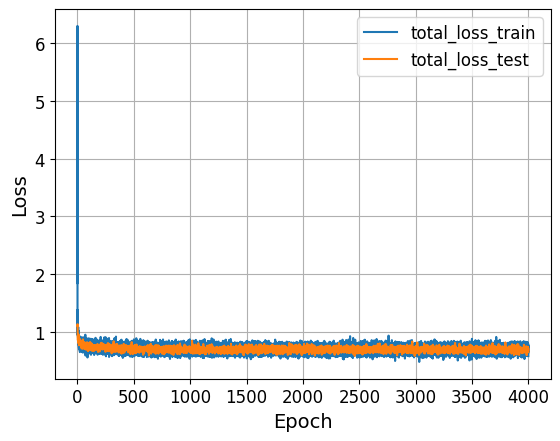

End of the training


In [ ]:
T = 800 # you could change it
# ====
# your code
# choose these parameters
BATCH_SIZE = 512
LR = 1e-2
EPOCHS = 4000
# ====

model = ConditionalMLP(input_dim=2, num_embeds=T)
ddpm = DDPM(num_timesteps=T, model=model)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# try your own optimizer/scheduler
optimizer = torch.optim.AdamW(ddpm.parameters(), lr=LR, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.995)

dgm_utils.train_model(
    model=ddpm,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    device=DEVICE,
    visualize_samples=False,
)

Now let's sample from our trained model.

100%|██████████| 800/800 [00:03<00:00, 250.34it/s]


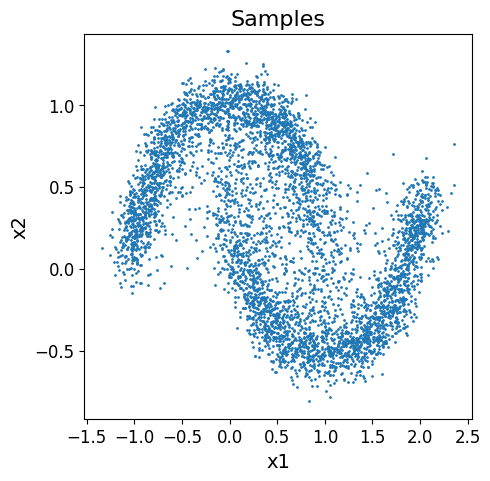

In [ ]:
samples = ddpm.sample(num_samples=5000).cpu()

dgm_utils.visualize_2d_samples(samples, title="Samples")

Now let's see how denoising looks like (similarly to forward noising process).

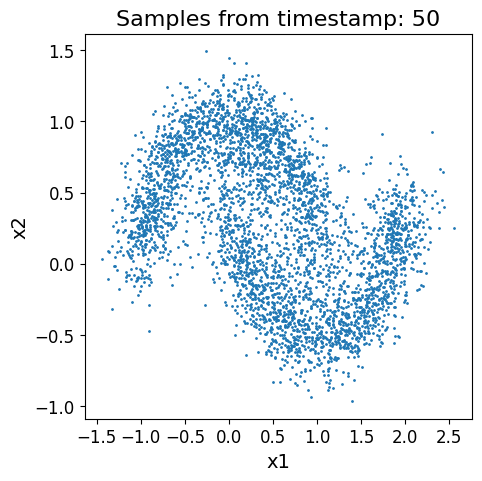

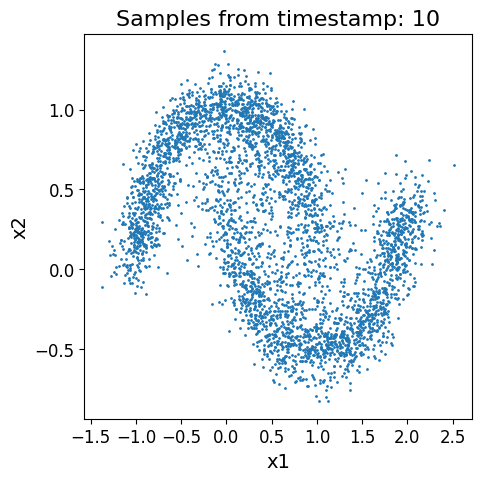

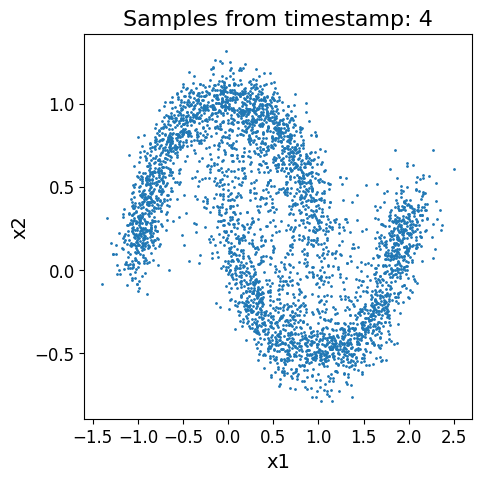

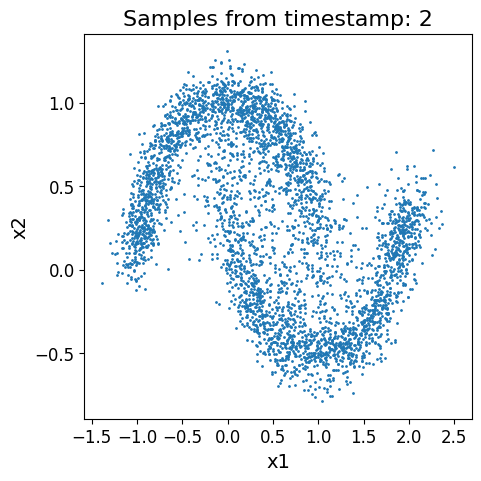

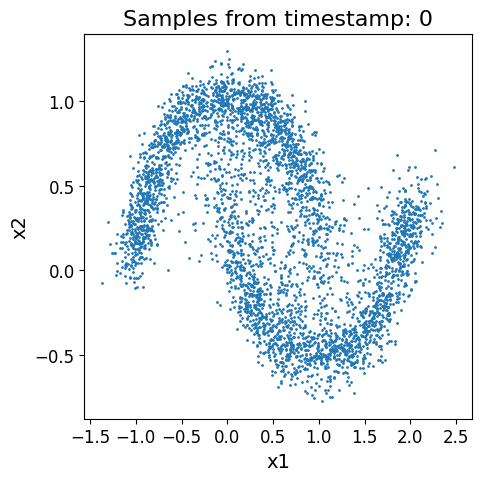

In [ ]:
timestamps=[0, 2, 4, 10, 50]

x = torch.randn(train_data.shape[0], 2, requires_grad=False).to(ddpm.device)
for i in range(ddpm.num_timesteps - 1, -1, -1):
    t = torch.tensor(i, dtype=torch.long, requires_grad=False).expand(x.shape[0]).to(ddpm.device)
    with torch.no_grad():
        eps = ddpm.model(x, t)
        x = ddpm.reverse_diffusion.get_samples(xt=x, eps=eps, t=t)
    if i in reversed(timestamps):
        x_ = x.cpu()
        dgm_utils.visualize_2d_samples(x_, title=f"Samples from timestamp: {i}")

## Task3: DDPM on MNIST (4pt)

Let apply our diffusion model to the MNIST dataset.

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 36943774.66it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1009262.26it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9464191.10it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3431291.20it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



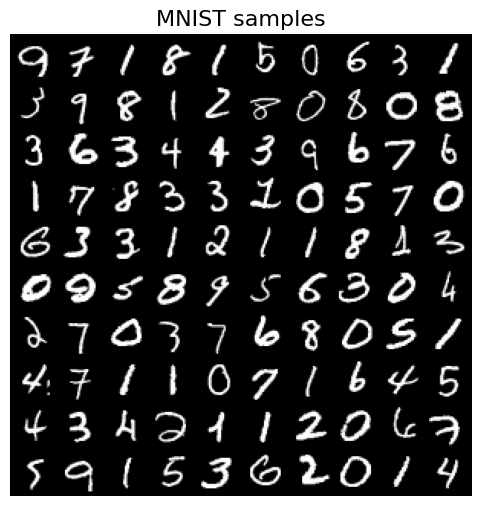

In [ ]:
train_data, test_data = dgm_utils.load_dataset("mnist", flatten=False, binarize=False)

dgm_utils.visualize_images(train_data, "MNIST samples")

Let's take a look at the forward process for the MNIST images.

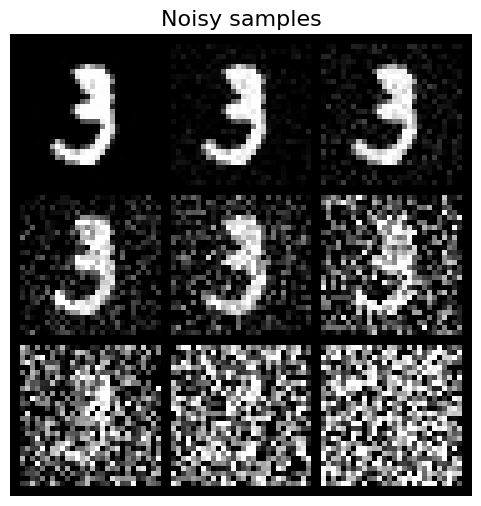

In [ ]:
T = 1000

fdiff = ForwardDiffusion(num_timesteps=T)

timestamps=[0, 50, 100, 200, 300, 500, 600, 800, 999]

plot_n_steps = len(timestamps)
samples = []
x0 = train_data[10:11]
x0 = 2 * x0 - 1
for i, t in enumerate(timestamps):
    x = fdiff.get_samples(x0=torch.from_numpy(x0), t=torch.ones((x0.shape[0], 1)).long() * t)
    samples.append(x.cpu().numpy())

samples = np.concatenate(samples)
samples = 0.5 * samples + 0.5
dgm_utils.show_samples(samples, title="Noisy samples")

The model is written for you. We will use conditioned ResNet architecture. But you could change it if you want.

In [ ]:
class ConditionedResnetBlock(nn.Module):
    def __init__(self, dim: int, num_embeddings: int) -> None:
        super().__init__()
        # you could experiment with this architecture
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(dim, dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(dim, dim, kernel_size=1),
        )
        self.dim = dim
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=dim)

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        time_embed = self.embedding(y).view(-1, self.dim, 1, 1)
        return x + self.block(x + time_embed)


class ConditionedSimpleResnet(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, n_filters: int, n_blocks: int, num_embeddings: int
    ) -> None:
        super().__init__()
        # you could experiment with this architecture
        self.first_block = nn.Sequential(
            nn.Conv2d(in_channels, n_filters, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.layers = nn.Sequential(*[ConditionedResnetBlock(n_filters, num_embeddings) for _ in range(n_blocks)])
        self.last_block = nn.Sequential(
            nn.ReLU(), nn.Conv2d(n_filters, out_channels, kernel_size=3, padding=1)
        )
        self.n_filters = n_filters

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        x = self.first_block(x)
        for layer in self.layers:
            x = layer(x, t)
        x = self.last_block(x)
        return x


def test_conditioned_resnet():
    model = ConditionedSimpleResnet(in_channels=1, out_channels=1, n_filters=16, n_blocks=1, num_embeddings=2)
    x = torch.rand((1, 1, 28, 28))
    t = torch.zeros(size=(1,), dtype=torch.long)
    out1 = model(x, t)
    t = torch.ones(size=(1,), dtype=torch.long)
    out2 = model(x, t)
    assert not np.allclose(out1.detach().numpy(), out2.detach().numpy())


test_conditioned_resnet()

Here we redefine two methods. Just to scale the data and clamp final samples.

In [ ]:
class DDPMMNIST(DDPM):

    def sample(self, num_samples: int):
        x = super().sample(num_samples)
        return torch.clamp(0.5 * x + 0.5, -1.0, 1.0)

    def loss(self, x0):
        x0 = 2.0 * x0 - 1.0
        return super().loss(x0)

That is all. We are ready to train our model.

Let's draw samples from the trained model.

In [ ]:
ddpm_mnist = ddpm_mnist.to(DEVICE)

samples = ddpm_mnist.sample(num_samples=25).cpu().numpy()

dgm_utils.show_samples(samples, title="Samples")

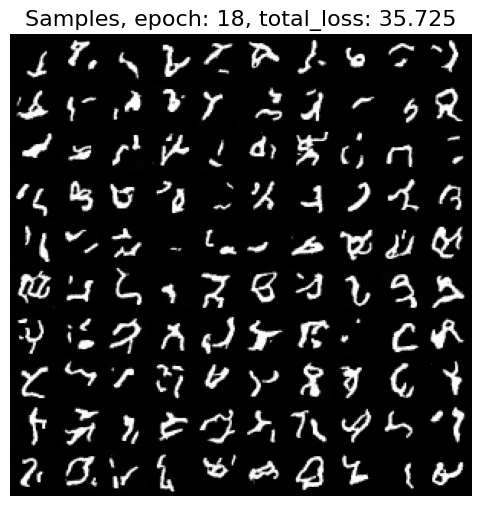

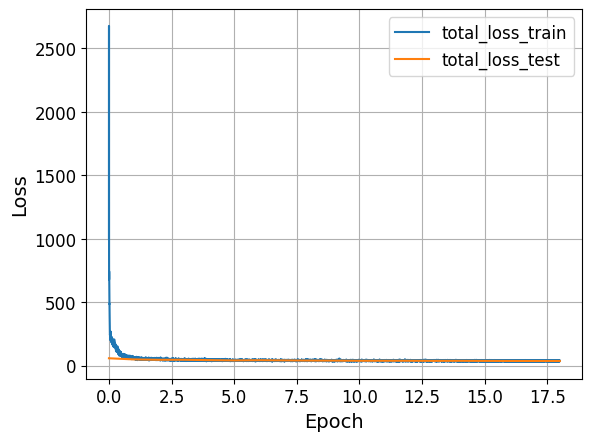

KeyboardInterrupt: 

In [ ]:
T = 1000
# ====
# your code
# choose these parameters
BATCH_SIZE = 128
LR = 5e-4
WEIGHT_DECAY = 0.97
EPOCHS = 40
N_FILTERS = 256
N_BLOCKS = 4
# ====

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

model_mnist = ConditionedSimpleResnet(in_channels=1, out_channels=1, n_filters=N_FILTERS, n_blocks=N_BLOCKS, num_embeddings=T)
ddpm_mnist = DDPMMNIST(num_timesteps=T, model=model_mnist)

# try your own optimizer/scheduler
optimizer = torch.optim.Adam(ddpm_mnist.parameters(), lr=LR) #, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

dgm_utils.train_model(
    model=ddpm_mnist,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    device=DEVICE,
)

100%|██████████| 1000/1000 [00:22<00:00, 44.72it/s]


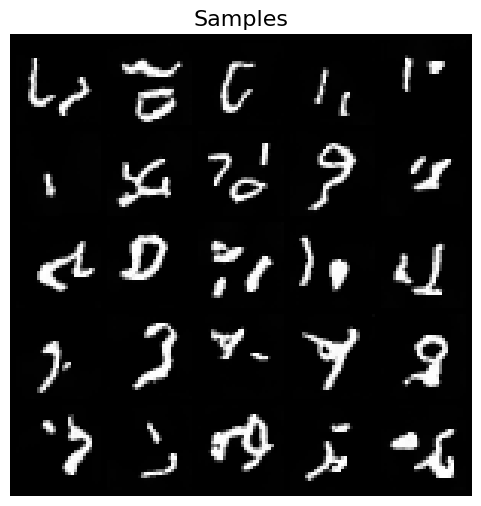

In [ ]:
ddpm_mnist = ddpm_mnist.to(DEVICE)

samples = ddpm_mnist.sample(num_samples=25).cpu().numpy()

dgm_utils.show_samples(samples, title="Samples")